
## 📓 Notebook Manager

This cell initializes the widgets required for managing your research notebook. Please run the cell below to enable functionality for:
- Exporting cells tagged with `export` into a `clean` notebook
- Generating a dynamic Table of Contents (TOC)
- Exporting the notebook to GitHub-compatible Markdown

➡️ **Be sure to execute the next cell before continuing with any editing or exporting.**

In [ ]:
# Cell 1 - Workflow Tools
import sys
sys.path.insert(0, '../../lib')
sys.path.insert(0, '../../scripts') 

from notebook_tools import TOCWidget, ExportWidget
import ipywidgets as widgets


# Create widget instances
toc = TOCWidget()
export = ExportWidget()

# Create horizontal layout
left_side = widgets.VBox([toc.button, export.button, toc.status])
right_side = widgets.VBox([toc.output, export.output])

# Display side by side
display(widgets.HBox([left_side, right_side]))

## 📑 Table of Contents (Auto-Generated)

This section will automatically generate a table of contents for your research notebook once you run the **Generate TOC** function. The table of contents will help you navigate through your data collection, analysis, and findings as your citizen science project develops.

➡️ **Do not edit this cell manually. It will be overwritten automatically.**


<!-- TOC -->
# Table of Contents

- [📓 Notebook Manager](#📓-notebook-manager)
- [📑 Table of Contents (Auto-Generated)](#📑-table-of-contents-(auto-generated))
- [📂 Load Experiment Data](#📂-load-experiment-data)
  - [Process](#process)
  - [Input Requirements](#input-requirements)
- [🖼️ Frame Preview & Verification](#🖼️-frame-preview-&-verification)
  - [Process](#process)
  - [Quality Indicators](#quality-indicators)
- [📐 Annotation Guidelines](#📐-annotation-guidelines)
  - [Annotation Planning Considerations](#annotation-planning-considerations)
  - [Vehicle Classification Approach](#vehicle-classification-approach)
  - [Quality Framework](#quality-framework)
- [💾 Export & Validation](#💾-export-&-validation)
  - [Export Process](#export-process)
  - [Dataset Structure](#dataset-structure)
  - [Validation Steps](#validation-steps)

<!-- /TOC -->


## 📂 Load Experiment Data

This cell loads preprocessed experiment data and verifies frames are ready for annotation.

### Process
- Loads experiment metadata and configuration
- Verifies normalized RGB frames exist and are accessible
- Displays experiment summary and frame statistics
- Confirms data integrity before CVAT import

### Input Requirements
- Completed preprocessing from v2_01_experiment_preprocessing_template
- experiment_summary.json with frame locations
- Normalized RGB frames in /normalized/ directory

**Note**: Ensure preprocessing notebook completed successfully before running annotation workflow.

In [6]:
# load experiment data
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# experiment configuration - update these paths to match your preprocessing output
EXPERIMENT_CONFIG = {
    'EXPERIMENT_NAME': 'car_counting_v1',
    'CAMERA_ID': 'ATL-1005', 
    'BATCH_DATE': '20250620',
    'BASE_PATH': Path('../../data/experiments')
}

# construct paths
date_formatted = f"{EXPERIMENT_CONFIG['BATCH_DATE'][:4]}-{EXPERIMENT_CONFIG['BATCH_DATE'][4:6]}-{EXPERIMENT_CONFIG['BATCH_DATE'][6:8]}"
experiment_dir = EXPERIMENT_CONFIG['BASE_PATH'] / EXPERIMENT_CONFIG['EXPERIMENT_NAME'] / date_formatted / EXPERIMENT_CONFIG['CAMERA_ID']

# load experiment metadata
metadata_file = experiment_dir / 'metadata.json'
summary_file = experiment_dir / 'experiment_summary.json'

if not metadata_file.exists():
    raise FileNotFoundError(f"Experiment metadata not found: {metadata_file}")
if not summary_file.exists():
    raise FileNotFoundError(f"Experiment summary not found: {summary_file}")

with open(metadata_file, 'r') as f:
    metadata = json.load(f)

with open(summary_file, 'r') as f:
    summary = json.load(f)

# verify normalized frames exist
normalized_dir = Path(summary['annotation_directory'])
if not normalized_dir.exists():
    raise FileNotFoundError(f"Normalized frames directory not found: {normalized_dir}")

frame_files = sorted(normalized_dir.glob("frame_*.jpg"))

print("Experiment Data Loaded Successfully")
print("=" * 50)
print(f"Experiment: {metadata['experiment_name']}")
print(f"Camera: {metadata['camera_id']}")
print(f"Source video: {metadata['source_video']}")
print(f"Processing date: {metadata['processing_timestamp'][:10]}")

print(f"\nFrame Information:")
print(f"  Frames ready for annotation: {len(frame_files)}")
print(f"  Frame directory: {normalized_dir}")
print(f"  Quality metrics available: {summary['processing_stages']['2_quality_analyzed']} frames")

print(f"\nQuality Summary:")
print(f"  Average brightness: {summary['quality_metrics']['avg_brightness']:.1f}")
print(f"  Average blur score: {summary['quality_metrics']['avg_blur_score']:.0f}")
print(f"  Brightness range: {summary['quality_metrics']['brightness_range'][0]:.1f} - {summary['quality_metrics']['brightness_range'][1]:.1f}")

# store for use in other cells
ANNOTATION_CONFIG = {
    'experiment_dir': experiment_dir,
    'normalized_dir': normalized_dir,
    'frame_files': frame_files,
    'metadata': metadata,
    'summary': summary
}

print(f"\n✓ Ready for CVAT annotation setup")

Experiment Data Loaded Successfully
Experiment: car_counting_v1
Camera: ATL-1005
Source video: ATL-1005_20250620_120641.mp4
Processing date: 2025-06-21

Frame Information:
  Frames ready for annotation: 50
  Frame directory: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/normalized
  Quality metrics available: 50 frames

Quality Summary:
  Average brightness: 102.6
  Average blur score: 3584
  Brightness range: 100.4 - 103.5

✓ Ready for CVAT annotation setup


## 🖼️ Frame Preview & Verification

This cell displays sample frames to verify they are ready for annotation and shows quality distribution.

### Process
- Displays grid of sample frames from normalized dataset
- Shows quality metrics overlay for annotation planning
- Verifies RGB color accuracy and image clarity
- Identifies potential annotation challenges

### Quality Indicators
- **Brightness**: Adequate lighting for vehicle detection
- **Sharpness**: Sufficient detail for bounding boxes  
- **Color**: Correct RGB representation for visual annotation

**Note**: Review frames for vehicle visibility before proceeding to CVAT setup.

Frame Preview & Verification
Quality data loaded: 50 frames


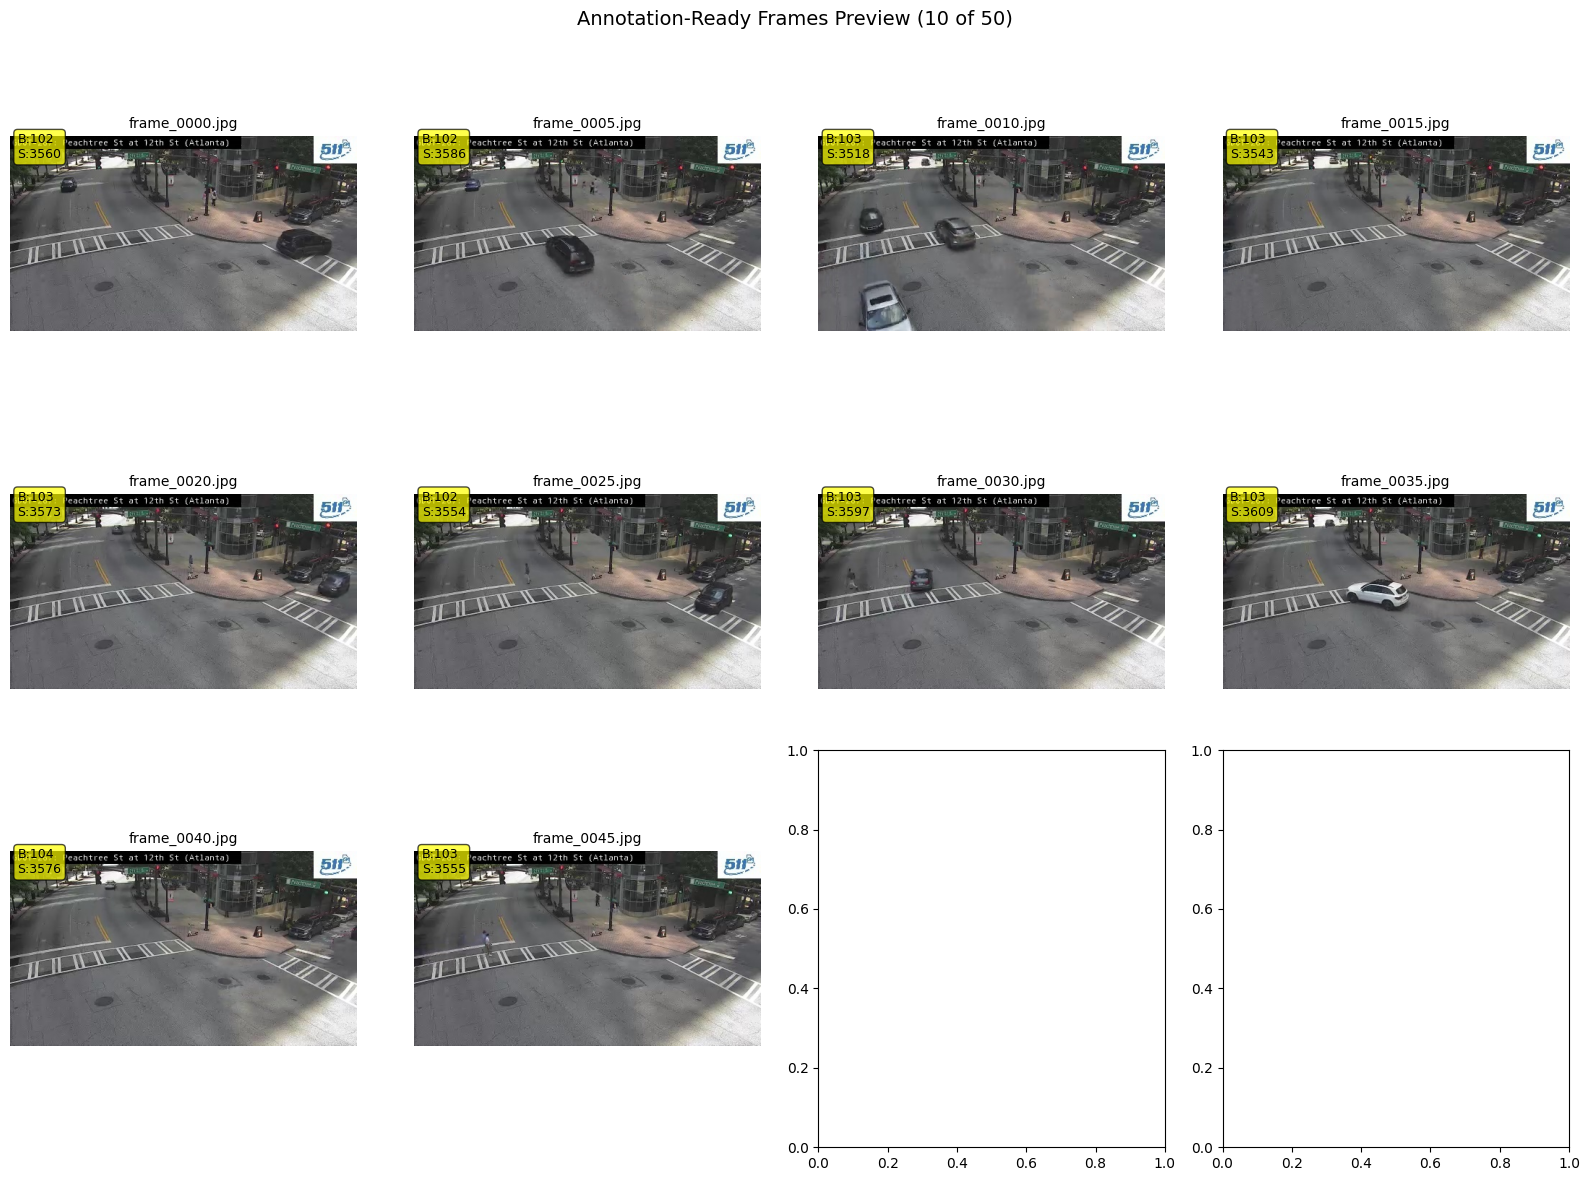


Annotation Readiness Checklist:
✓ RGB color format: Verified (using plt.imread)
✓ Frame count: 50 frames available
✓ File format: JPEG (CVAT compatible)
✓ Directory structure: Organized in ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/normalized
✓ Quality metrics: B=103, S=3584
⚠ 5 potentially dark frames - may need careful annotation
⚠ 5 potentially blurry frames - may affect bounding box precision

🎯 Ready for CVAT import
Import directory: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/normalized


In [7]:
# frame preview and verification
import matplotlib.pyplot as plt
import pandas as pd

print("Frame Preview & Verification")
print("=" * 40)

# load quality data if available
quality_file = ANNOTATION_CONFIG['experiment_dir'] / 'quality_report.csv'
if quality_file.exists():
    quality_df = pd.read_csv(quality_file)
    print(f"Quality data loaded: {len(quality_df)} frames")
else:
    quality_df = None
    print("No quality data found")

# display sample frames (every 5th frame for variety)
sample_indices = list(range(0, len(ANNOTATION_CONFIG['frame_files']), 5))[:12]
sample_frames = [ANNOTATION_CONFIG['frame_files'][i] for i in sample_indices]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle(f'Annotation-Ready Frames Preview ({len(sample_frames)} of {len(ANNOTATION_CONFIG["frame_files"])})', fontsize=14)

for i, frame_path in enumerate(sample_frames):
    row = i // 4
    col = i % 4
    
    # load RGB frame
    frame_rgb = plt.imread(str(frame_path))
    axes[row, col].imshow(frame_rgb)
    
    # overlay quality metrics if available
    if quality_df is not None:
        quality_info = quality_df[quality_df['frame'] == frame_path.name]
        if not quality_info.empty:
            brightness = quality_info['brightness'].values[0]
            blur_score = quality_info['blur_score'].values[0]
            axes[row, col].text(10, 30, f'B:{brightness:.0f}\nS:{blur_score:.0f}', 
                               bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                               fontsize=9, color='black')
    
    axes[row, col].set_title(f'{frame_path.name}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# annotation readiness checklist
print(f"\nAnnotation Readiness Checklist:")
print(f"✓ RGB color format: Verified (using plt.imread)")
print(f"✓ Frame count: {len(ANNOTATION_CONFIG['frame_files'])} frames available")
print(f"✓ File format: JPEG (CVAT compatible)")
print(f"✓ Directory structure: Organized in {ANNOTATION_CONFIG['normalized_dir']}")

if quality_df is not None:
    avg_brightness = quality_df['brightness'].mean()
    avg_blur = quality_df['blur_score'].mean()
    print(f"✓ Quality metrics: B={avg_brightness:.0f}, S={avg_blur:.0f}")
    
    # identify potential annotation challenges
    dark_frames = len(quality_df[quality_df['brightness'] < quality_df['brightness'].quantile(0.1)])
    blurry_frames = len(quality_df[quality_df['blur_score'] < quality_df['blur_score'].quantile(0.1)])
    
    if dark_frames > 0:
        print(f"⚠ {dark_frames} potentially dark frames - may need careful annotation")
    if blurry_frames > 0:
        print(f"⚠ {blurry_frames} potentially blurry frames - may affect bounding box precision")

print(f"\n🎯 Ready for CVAT import")
print(f"Import directory: {ANNOTATION_CONFIG['normalized_dir']}")

## 📐 Annotation Guidelines

This section provides framework for developing annotation standards based on experiment requirements.

### Annotation Planning Considerations
- **Bounding box approach**: Define standards for box placement
- **Occlusion handling**: Establish rules for partially visible objects
- **Size thresholds**: Determine minimum annotation requirements
- **Edge cases**: Define treatment of objects at frame boundaries

### Vehicle Classification Approach
- **Class definitions**: Define vehicle categories based on experiment goals
- **Classification criteria**: Establish consistent identification rules
- **Ambiguous cases**: Define handling of unclear vehicle types

### Quality Framework
- **Consistency standards**: Maintain uniform annotation approach
- **Coverage requirements**: Define annotation completeness expectations
- **Validation approach**: Establish quality checking methods

**Goal**: Develop annotation strategy tailored to vehicle counting experiment needs.

Annotation Guidelines & Reference Examples


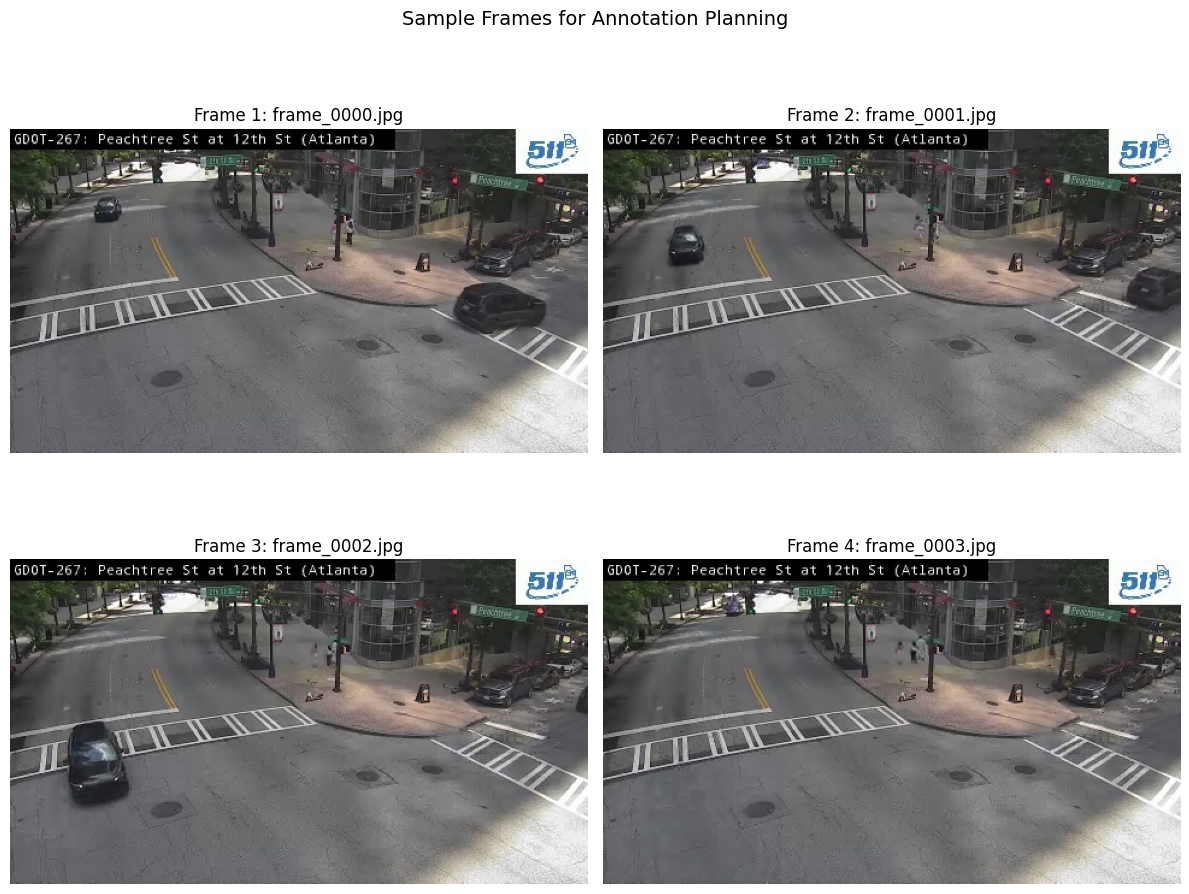


📋 Annotation Planning:
• Total frames available: 50
• Frame format: RGB JPEG
• Frame directory: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/normalized
• Quality data: Available for annotation decisions

🎯 Annotation Objectives:
• Identify vehicles in traffic camera frames
• Create bounding box annotations
• Generate training data for counting models
• Export in YOLO format for model training

📝 Annotation Workflow:
1. Review frames in CVAT annotation interface
2. Define vehicle classes based on experiment needs
3. Create bounding box annotations
4. Maintain consistency across frames
5. Export annotations in YOLO format

📊 Frame Characteristics:
• Average brightness: 102.6
• Average sharpness: 3584
• Quality range available for annotation planning

✓ Ready for manual annotation in CVAT
Define specific annotation criteria based on experiment requirements


In [8]:

# annotation guidelines and reference examples
import matplotlib.pyplot as plt

print("Annotation Guidelines & Reference Examples")
print("=" * 45)

# display sample frames for annotation planning
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Sample Frames for Annotation Planning', fontsize=14)

sample_frames = ANNOTATION_CONFIG['frame_files'][:4]

for i, frame_path in enumerate(sample_frames):
    row = i // 2
    col = i % 2
    
    frame_rgb = plt.imread(str(frame_path))
    axes[row, col].imshow(frame_rgb)
    axes[row, col].set_title(f'Frame {i+1}: {frame_path.name}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("\n📋 Annotation Planning:")
print(f"• Total frames available: {len(ANNOTATION_CONFIG['frame_files'])}")
print(f"• Frame format: RGB JPEG")
print(f"• Frame directory: {ANNOTATION_CONFIG['normalized_dir']}")
print(f"• Quality data: Available for annotation decisions")

print("\n🎯 Annotation Objectives:")
print("• Identify vehicles in traffic camera frames")
print("• Create bounding box annotations")
print("• Generate training data for counting models")
print("• Export in YOLO format for model training")

print("\n📝 Annotation Workflow:")
print("1. Review frames in CVAT annotation interface")
print("2. Define vehicle classes based on experiment needs")
print("3. Create bounding box annotations")
print("4. Maintain consistency across frames")
print("5. Export annotations in YOLO format")

print("\n📊 Frame Characteristics:")
if ANNOTATION_CONFIG.get('summary'):
    print(f"• Average brightness: {ANNOTATION_CONFIG['summary']['quality_metrics']['avg_brightness']:.1f}")
    print(f"• Average sharpness: {ANNOTATION_CONFIG['summary']['quality_metrics']['avg_blur_score']:.0f}")
    print(f"• Quality range available for annotation planning")

print("\n✓ Ready for manual annotation in CVAT")
print("Define specific annotation criteria based on experiment requirements")

## 💾 Export & Validation

This section guides export of annotations from CVAT and validation of the training dataset.

### Export Process
- **Format selection**: Choose YOLO format for model training
- **File organization**: Structure annotations with corresponding images
- **Quality verification**: Validate annotation completeness

### Dataset Structure
- **Images**: Original frame files for training
- **Labels**: YOLO format text files with bounding box coordinates
- **Classes**: Class definitions file for model training

### Validation Steps
- **File integrity**: Verify all frames have corresponding labels
- **Format compliance**: Check YOLO format specifications
- **Annotation quality**: Review sample annotations for consistency

**Output**: Ready-to-use training dataset for YOLO model development.

In [9]:
# export and validation workflow
print("Export & Validation Workflow")
print("=" * 30)

# create annotations directory structure
annotations_dir = ANNOTATION_CONFIG['experiment_dir'] / 'annotations'
annotations_dir.mkdir(exist_ok=True)

print(f"📁 Dataset Structure Setup:")
print(f"  Base directory: {ANNOTATION_CONFIG['experiment_dir']}")
print(f"  Images: {ANNOTATION_CONFIG['normalized_dir']}")
print(f"  Annotations: {annotations_dir}")

print(f"\n📤 CVAT Export Instructions:")
print(f"1. Complete annotation in CVAT interface")
print(f"2. Go to CVAT project -> Actions -> Export dataset")
print(f"3. Select format: 'YOLO 1.1'")
print(f"4. Download exported annotations")
print(f"5. Extract to: {annotations_dir}")

print(f"\n📋 Expected Export Structure:")
print(f"  annotations/")
print(f"  ├── obj_train_data/     # YOLO label files (.txt)")
print(f"  ├── obj.names           # Class names")
print(f"  └── obj.data            # Dataset configuration")

print(f"\n✅ Dataset Validation Checklist:")
frame_count = len(ANNOTATION_CONFIG['frame_files'])
print(f"  □ Frame count matches: {frame_count} image files")
print(f"  □ Annotation files present for each frame")
print(f"  □ YOLO format validation (class_id x_center y_center width height)")
print(f"  □ Class definitions file exists")
print(f"  □ Coordinate ranges: 0.0 to 1.0 (normalized)")

print(f"\n🎯 Training Dataset Ready:")
print(f"  Images: {ANNOTATION_CONFIG['normalized_dir']}")
print(f"  Labels: {annotations_dir}/obj_train_data/")
print(f"  Classes: {annotations_dir}/obj.names")

print(f"\n📊 Annotation Summary:")
print(f"  Total frames: {frame_count}")
print(f"  Source video: {ANNOTATION_CONFIG['metadata']['source_video']}")
print(f"  Camera: {ANNOTATION_CONFIG['metadata']['camera_id']}")
print(f"  Experiment: {ANNOTATION_CONFIG['metadata']['experiment_name']}")

print(f"\n🚀 Next Steps:")
print(f"  1. Complete CVAT annotation and export")
print(f"  2. Validate YOLO format compliance")
print(f"  3. Proceed to model training notebook")
print(f"  4. Train initial vehicle counting model")

print(f"\n✓ Annotation workflow template complete")

Export & Validation Workflow
📁 Dataset Structure Setup:
  Base directory: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005
  Images: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/normalized
  Annotations: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/annotations

📤 CVAT Export Instructions:
1. Complete annotation in CVAT interface
2. Go to CVAT project -> Actions -> Export dataset
3. Select format: 'YOLO 1.1'
4. Download exported annotations
5. Extract to: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/annotations

📋 Expected Export Structure:
  annotations/
  ├── obj_train_data/     # YOLO label files (.txt)
  ├── obj.names           # Class names
  └── obj.data            # Dataset configuration

✅ Dataset Validation Checklist:
  □ Frame count matches: 50 image files
  □ Annotation files present for each frame
  □ YOLO format validation (class_id x_center y_center width height)
  □ Class definitions file exists
  □ Coordinate ranges: 0.